# Concepts embeddings

A first experiment in creating embeddings for concepts. 

## Approach 

1. count the number of times each concept appears in a document, and assemble this in a matrix DxC where D are document rows and C are concept columns 
2. normalise matrix row-wise to get proportions per document
3. run clustering model

## Results

Representations of documents by the concepts that contain them seems promising - a simple representation produces seemingly meaningful clusters

## Future improvements

* a more elaborate clustering approach
* more investigation into normalising by *overall concept popularity* to even out the clusters (i.e. should more clusters contain more common concepts?)
* better cluster labelling: at the moment clusters are labelled by the top 5 occurring concepts in them - this could be improved by e.g. using a dropoff or setting a minimum number of occurrences of a concept
* creating at a confusion matrix to identify whether concept co-occurrences are due to the concepts getting confused by the classifiers
* looking at GST explorer search logs to see how the clusters relate to the common groups of filters users are selecting
* finding representative text blocks for a cluster

In [ ]:
import sys

!{sys.executable} -m pip install plotly wikipedia

In [143]:
import sys
import os
from pathlib import Path
import itertools
from collections import Counter
from typing import Optional

import pandas as pd
import matplotlib.pyplot as plt
import wikipedia
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import plotly.express as px

sys.path.append("../../..")

from src.opensearch.index_data import get_dataset_and_filter_values

In [3]:
dataset, _ = get_dataset_and_filter_values(
    os.environ["DOCS_DIR_GST"], 
    Path("/Users/kalyan/Documents/CPR/unfccc-global-stocktake-documents/CPR_UNFCCC_MASTER.csv"),
    Path("../../../concepts/")
)KMeans

INFO:src.opensearch.index_data:Loading scraper CSV
INFO:src.opensearch.index_data:Loading dataset of parsed documents


  0%|          | 0/1697 [00:00<?, ?it/s]

  0%|          | 0/1679 [00:00<?, ?it/s]

INFO:src.opensearch.index_data:Loaded 1679 documents. 0 documents failed to load.
INFO:src.opensearch.index_data:Loading spans from concepts directory
INFO:src.opensearch.index_data:Adding spans to dataset


0docs [00:00, ?docs/s]

In [23]:
# create flat data structure
flat_data = []

for document in tqdm(dataset.documents):
    doc_dict = document.dict(
        exclude={
            "text_blocks",
            "_text_block_idx_hash_map",
            "page_metadata",
            "document_metadata",
        }
    )
    metadata_dict = document.document_metadata.dict()
    if document.text_blocks:
        spans = []

        for block in document.text_blocks:
            spans.extend(block.spans)

        span_types = [f"SPAN: {span.type}" for span in spans]

    else:
        span_types = []

    flat_data.append(doc_dict | metadata_dict | dict(Counter(span_types)))

  0%|          | 0/1679 [00:00<?, ?it/s]

In [34]:
flat_df = pd.DataFrame.from_records(flat_data).fillna(0)
flat_df.head()

,document_id,document_name,document_source_url,document_content_type,document_md5_sum,languages,translated,has_valid_text,source,author,...,SPAN: Technologies (Adaptation) – Buildings And Homes Technologies,SPAN: Renewables – Renewable Hydrogen,SPAN: Vulnerable Groups – Migrants,SPAN: Deforestation – Woodlands,SPAN: Deforestation – Revegetation,SPAN: Technologies (Mitigation) – Industrial Technologies,SPAN: Technologies (Adaptation) – Transport Technologies,SPAN: Equity And Just Transition – Needs-Based Approach,SPAN: Vulnerable Groups – People With Chronic Diseases,SPAN: Technologies (Adaptation) – Energy And Power Technologies
0,UNFCCC.party.589.0,Guyana First NDC,https://unfccc.int/sites/default/files/NDC/202...,application/pdf,b28e637a9218a83451cdc7c4da287176,[en],False,True,GST-related documents,[Guyana],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,UNFCCC.non-party.1328.0,Technical analysis of the first biennial updat...,https://unfccc.int/sites/default/files/resourc...,application/pdf,4e6f0eec934e75d5b6dddd51d38755f0,[en],False,True,GST-related documents,[UNFCCC Secretariat],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,UNFCCC.party.1435.0,The government of Japan Submission to the Tech...,https://unfccc.int/sites/default/files/resourc...,application/pdf,6689b5dd5b31af0446c9a3d0b0b23edc,[en],False,True,GST-related documents,[Japan],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,UNFCCC.party.956.0,NIS to BUR3. Republic of Moldova.,https://unfccc.int/sites/default/files/resourc...,application/pdf,0918cc76405ed5ba820a5c8d0cab3f5b,[en],False,True,GST-related documents,[Moldova],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,UNFCCC.non-party.191.0,CAD2.0 Technical Dialogue inputs for the GST: ...,https://unfccc.int/sites/default/files/resourc...,application/pdf,25a1e936e611a092c15ed7bbb7f4e239,[en],False,True,GST-related documents,[CAD2],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
flat_df["document_type_flat"] = flat_df["types"].apply(lambda i: ", ".join(i))
flat_df["author_flat"] = flat_df["author"].apply(lambda i: ",".join(i))

In [244]:
vector_df = flat_df[[col for col in flat_df.columns if col.startswith("SPAN:")]]
vectors_norm = vector_df.copy()

# normalise across each column - for tf-idf-like representation
# vectors_norm = vectors_norm.div(vector_df.sum(axis=0), axis=1).fillna(0)

# normalise across each row - for unit norm vectors
vectors_norm = vectors_norm.div(vector_df.sum(axis=1), axis=0).fillna(0)

# convert to numpy array
vectors_norm_array = vectors_norm.values

pca = PCA(n_components=2)

projection_2d = pca.fit_transform(vectors_norm_array)

flat_df["pca_x"] = projection_2d[:, 0]
flat_df["pca_y"] = projection_2d[:, 1]

In [252]:
cluster_model = KMeans(n_clusters=18, random_state=42).fit(vectors_norm_array)
# cluster_model = AgglomerativeClustering(n_clusters=18).fit(vectors_norm)
flat_df["cluster"] = cluster_model.labels_
vectors_norm["cluster"] = cluster_model.labels_

# Get top N types per cluster
cluster_means = vectors_norm.groupby("cluster").mean()

SPAN_COLS = [col for col in flat_df.columns if col.startswith("SPAN:")]
TOP_N_TYPES = 5

cluster_top_types_map = dict()

for cluster, row in cluster_means.iterrows():
    top_types = row[SPAN_COLS].nlargest(TOP_N_TYPES).to_dict()
    top_types = {t.removeprefix("SPAN: "): v for t, v in top_types.items()}

    cluster_top_types_map[cluster] = top_types

flat_df["cluster_top_types"] = (
    flat_df["cluster"].map(cluster_top_types_map).apply(lambda i: "\n".join(i))
)

cluster_sizes = flat_df.groupby("cluster").count()["document_id"]

/Users/kalyan/Library/Caches/pypoetry/virtualenvs/experiment-template-Q6O6vM4r-py3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



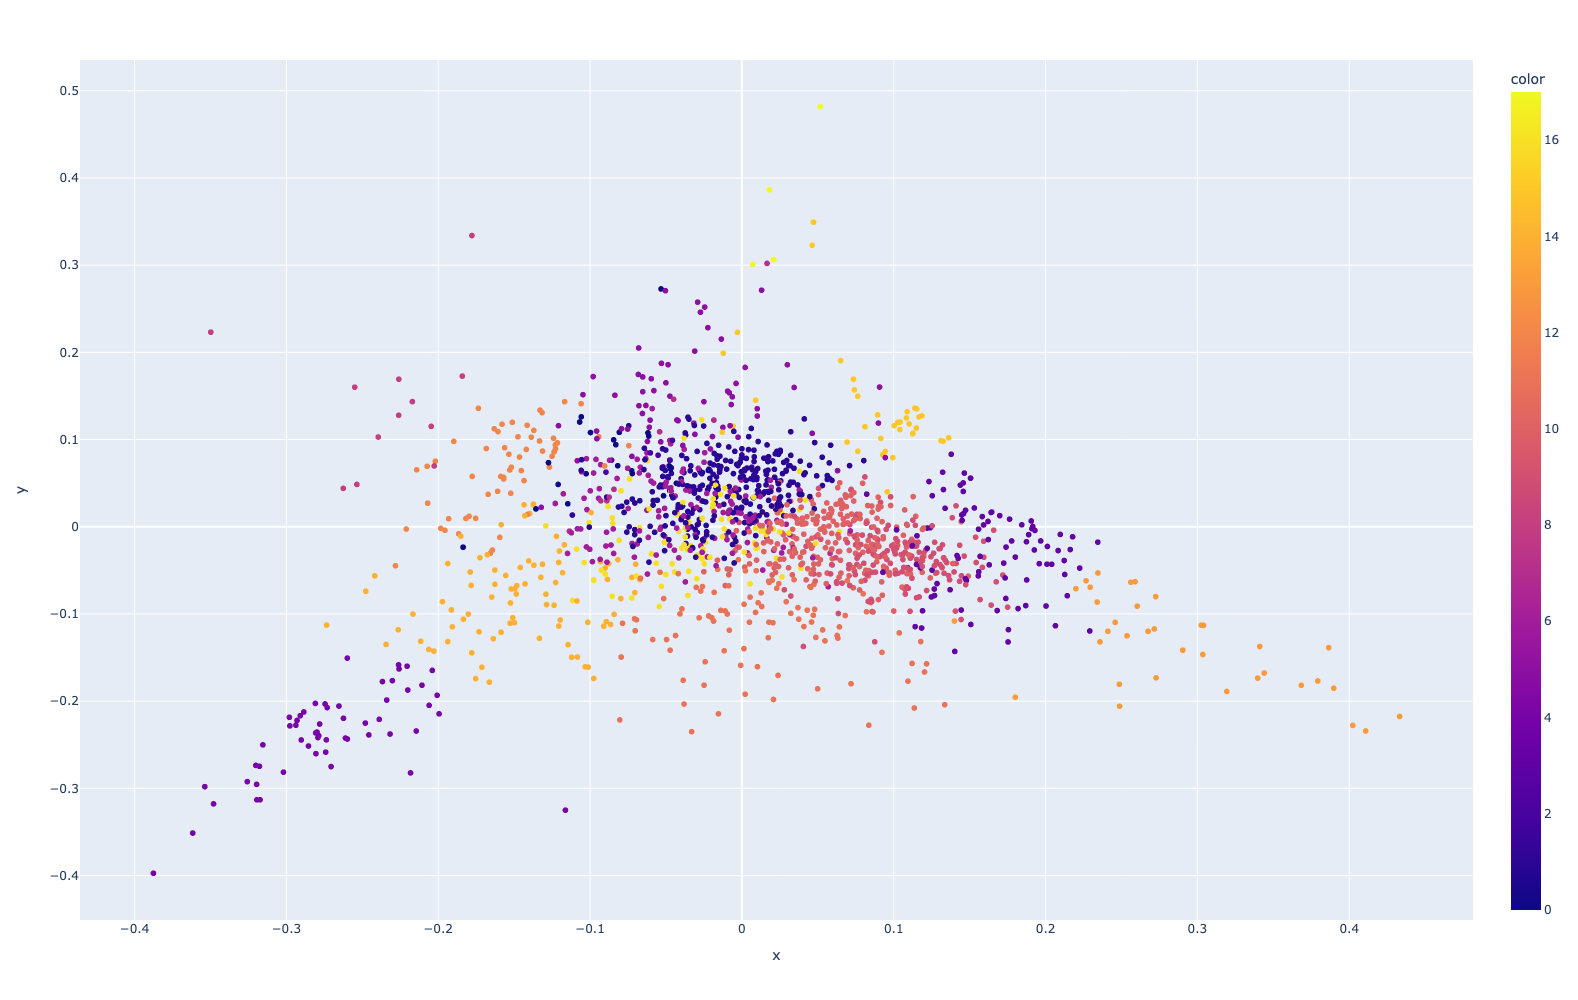

In [253]:
fig = px.scatter(
    x=flat_df["pca_x"],
    y=flat_df["pca_y"],
    hover_name=flat_df["document_name"],
    hover_data={"authors": flat_df["author_flat"]},
    color=flat_df["cluster"],
    width=1400,
    height=1000,
)

fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=-0.5, xanchor="right", x=1)
)

fig.show()

In [254]:
# print cluster types

for cluster, types in cluster_top_types_map.items():
    print(f"cluster {cluster} ({cluster_sizes[cluster]} docs)")
    print(
        "\n".join(
            f"{type}: {round(proportion, 3)}" for type, proportion in types.items()
        )
    )
    print()

cluster 0 (25 docs)
Policy Instruments – Information And Education: 0.181
Vulnerable Groups – Indigenous People: 0.084
Sectors – Insurance & Financial Services: 0.066
Barriers And Challenges – Challenges: 0.053
Policy Instruments – Economic Instruments: 0.052

cluster 1 (306 docs)
Sectors – Agriculture, Forestry And Other Land Use: 0.096
Greenhouse Gases – Emissions: 0.072
Financial Flows – Financial Flow: 0.057
Sectors – Energy: 0.053
Policy Instruments – Information And Education: 0.049

cluster 2 (126 docs)
International Cooperation – International Cooperation: 0.008
Equity And Just Transition – Inequality & Human Rights: 0.006
Vulnerable Groups – Women And Girls: 0.003
Equity And Just Transition – Equity And Justice: 0.003
Vulnerable Groups – Indigenous People: 0.002

cluster 3 (95 docs)
Greenhouse Gases – Emissions: 0.247
Greenhouse Gases – Greenhouse Gases: 0.09
Sectors – Agriculture, Forestry And Other Land Use: 0.087
Sectors – Energy: 0.073
Sectors – Industry: 0.059

cluster 4 

In [255]:
with pd.option_context("display.max_colwidth", 200):
    cluster = 16
    print(f"cluster {cluster} ({cluster_sizes[cluster]} docs)")
    print(
        "\n".join(
            f"{type}: {round(proportion, 3)}"
            for type, proportion in cluster_top_types_map[cluster].items()
        )
    )
    display(
        flat_df.loc[
            flat_df["cluster"] == cluster,
            [
                "document_id",
                "document_name",
                # "document_source_url",
                "author",
                "author_is_party",
                "date",
            ],
        ]  # .sample(10, random_state=42)
    )

cluster 16 (90 docs)
Sectors – Energy: 0.09
Sectors – Industry: 0.073
Financial Flows – Financial Flow: 0.067
Greenhouse Gases – Emissions: 0.063
Policy Instruments – Economic Instruments: 0.056


,document_id,document_name,author,author_is_party,date
11,UNFCCC.non-party.1255.0,Submission for the first input phase of the global stocktake: International Network for Sustainable Energy,[International Network for Sustainable Energy (INFORSE)],False,2022-04-01
47,UNFCCC.party.632.0,India's Long-Term Low-Carbon Development Strategy,[India],True,2022-11-14
53,UNFCCC.non-party.257.0,Climate Action Pathway: Transport. Action Table,[Marrakech Partnership],False,2021-06-29
79,UNFCCC.non-party.13.0,Air Transport Action Group (ATAG) to the First Global Stocktake,[Air Transport Action Group (ATAG)],False,2022-05-17
82,UNFCCC.party.1223.0,Stratégie à long terme de la Belgique,[Belgium],True,2020-12-10
...,...,...,...,...,...
1572,UNFCCC.non-party.252.0,Climate Action Pathway: Industry. Action Table,[Marrakech Partnership],False,2021-05-27
1607,UNFCCC.party.758.0,Long term strategy on climate mitigation,[Netherlands],True,2020-12-11
1626,UNFCCC.party.1518.0,United Arab Emirates. National Communication (NC). NC 4.,[United Arab Emirates],True,2019-01-21
1627,UNFCCC.non-party.1454.0,Thermal Storage UK Global Stocktake submission,[Thermal Storage UK],False,2022-05-17
